In [1]:
%matplotlib notebook

import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle

Using TensorFlow backend.


In [2]:
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
values = devmodel.Data['smiles_string'].drop_duplicates()
print(values.shape)

/Users/wab665/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/wab665/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


(276,)


In [3]:
smile_max_length = values.map(len).max()
print(smile_max_length)

48


We may want to remove cations with more than 25 heavy atoms

<IPython.core.display.Javascript object>


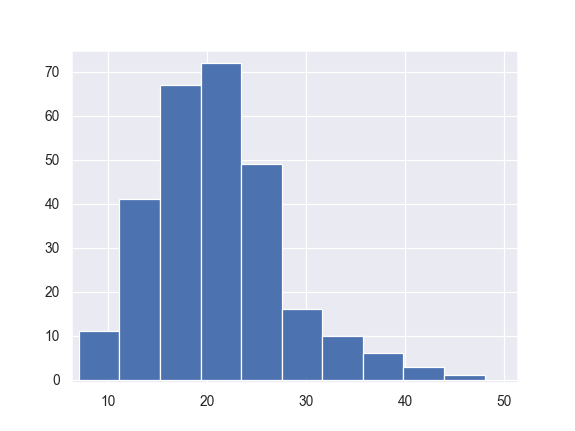

(array([11., 41., 67., 72., 49., 16., 10.,  6.,  3.,  1.]),
 array([ 7. , 11.1, 15.2, 19.3, 23.4, 27.5, 31.6, 35.7, 39.8, 43.9, 48. ]),
 <a list of 10 Patch objects>)

In [4]:
plt.hist(values.map(len))

In [5]:
def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))

In [6]:
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]

In [7]:
shuffle(padded_smiles)

In [8]:
def create_char_list(char_set, smile_series):
    for smile in smile_series:
        char_set.update(set(smile))
    return char_set

In [9]:
char_set = set()
char_set = create_char_list(char_set, padded_smiles)

In [10]:
print(len(char_set))
char_set

24


{' ',
 '#',
 '(',
 ')',
 '+',
 '-',
 '1',
 '2',
 '3',
 '=',
 'B',
 'C',
 'H',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'c',
 'l',
 'n',
 'r'}

In [11]:
char_list = list(char_set)
chars_in_dict = len(char_list)
char_to_index = dict((c, i) for i, c in enumerate(char_list))
index_to_char = dict((i, c) for i, c in enumerate(char_list))

In [12]:
char_to_index

{'+': 0,
 'n': 1,
 'P': 2,
 '[': 3,
 '\\': 4,
 ']': 5,
 '(': 6,
 'c': 7,
 'S': 8,
 'r': 9,
 '#': 10,
 '2': 11,
 ' ': 12,
 ')': 13,
 '=': 14,
 'C': 15,
 '1': 16,
 'N': 17,
 '3': 18,
 'O': 19,
 '-': 20,
 'B': 21,
 'H': 22,
 'l': 23}

In [13]:
X_train = np.zeros((len(padded_smiles), smile_max_length, chars_in_dict), dtype=np.float32)

In [14]:
X_train.shape

(275, 48, 24)

In [15]:
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

In [16]:
X_train, X_test = train_test_split(X_train, test_size=0.33, random_state=42)

In [17]:
X_train.shape

(184, 48, 24)

In [18]:
# need to build RNN to encode. some issues include what the 'embedded dimension' is (vector length of embedded sequence)

so some keras version stuff. 1.0 uses keras.losses to store its loss functions. 2.0 uses objectives. we'll just have to be consistent

In [19]:
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

Here I've adapted the exact architecture used in the [paper](https://github.com/maxhodak/keras-molecules/blob/master/molecules/model.py)

In [20]:
def Encoder(x, latent_rep_size, smile_max_length, epsilon_std = 0.01):
    h = Convolution1D(9, 9, activation = 'relu', name='conv_1')(x)
    h = Convolution1D(9, 9, activation = 'relu', name='conv_2')(h)
    h = Convolution1D(10, 11, activation = 'relu', name='conv_3')(h)
    h = Flatten(name = 'flatten_1')(h)
    h = Dense(435, activation = 'relu', name = 'dense_1')(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_rep_size),
                                  mean=0., stddev = epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

    z_mean = Dense(latent_rep_size, name='z_mean', activation = 'linear')(h)
    z_log_var = Dense(latent_rep_size, name='z_log_var', activation = 'linear')(h)

    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = smile_max_length * binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - \
                                 K.exp(z_log_var), axis = -1)
        return xent_loss + kl_loss

    return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,),
                             name='lambda')([z_mean, z_log_var]))

def Decoder(z, latent_rep_size, smile_max_length, charset_length):
    h = Dense(latent_rep_size, name='latent_input', activation = 'relu')(z)
    h = RepeatVector(smile_max_length, name='repeat_vector')(h)
    h = GRU(501, return_sequences = True, name='gru_1')(h)
    h = GRU(501, return_sequences = True, name='gru_2')(h)
    h = GRU(501, return_sequences = True, name='gru_3')(h)
    return TimeDistributed(Dense(charset_length, activation='softmax'),
                           name='decoded_mean')(h)

In [21]:
x = Input(shape=(smile_max_length, len(char_set)))

In [22]:
_, z = Encoder(x, latent_rep_size=292, smile_max_length=smile_max_length)

In [23]:
encoder = Model(x, z)

encoded_input looks like a dummy layer here:

In [24]:
encoded_input = Input(shape=(292,))

In [25]:
decoder = Model(encoded_input, Decoder(encoded_input, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

create a separate autoencoder model that combines the encoder and decoder (I guess the former cells are for accessing those separate parts of the model)

In [26]:
x1 = Input(shape=(smile_max_length, len(char_set)), name='input_1')

In [27]:
vae_loss, z1 = Encoder(x1, latent_rep_size=292, smile_max_length=smile_max_length)

In [28]:
autoencoder = Model(x1, Decoder(z1, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

we compile and fit

In [29]:
autoencoder.compile(optimizer='Adam', loss=vae_loss, metrics =['accuracy'])

In [30]:
autoencoder.fit(X_train, X_train, shuffle = True, validation_data=(X_test, X_test))

Train on 184 samples, validate on 91 samples
Epoch 1/1
184/184 [==============================] - 14s 75ms/step - loss: 8.2420 - acc: 0.4574 - val_loss: 7.5262 - val_acc: 0.1989


In [31]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))

In [32]:
test_smi = values[0]
test_smi = pad_smiles(test_smi, smile_max_length)
Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
for t, char in enumerate(test_smi):
    Z[0, t, char_to_index[char]] = 1
    
# autoencoder.

In [58]:
string = ""
for i in autoencoder.predict(Z):
    for j in i:
        index = sample(j)
        string += index_to_char[index]
print("\n callback guess: " + string)


 callback guess: )+CO[CB3-\)OCP(CC[C==) rrn+- 1C]2H=2Hnc)nNP+cn2P


In [34]:
values[0]

'CCCC[n+]1ccc(cc1)C'